In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('..')
from src.blindspot import BlindspotLModule, SpecTrainer
from src.utils import load_config

In [ ]:
name = 'm215l9e48k25s1bn1d1ep5000'
dir = '.'
ckpt = os.path.join(dir, f'{name}.ckpt')
config = load_config(os.path.join(dir, f'{name}.yaml'))
pl = BlindspotLModule.load_from_checkpoint(ckpt, config=config)

Creating b1_l9_e48_k25_s1_bn1_d1 model with T1 loss


In [5]:
config['data']['test_path'] = '/datascope/subaru/user/swei20/data/bosz50000/mag215/val_10k/dataset.h5'
config['data']['num_test_samples'] = 10000

/datascope/slurm/miniconda3/envs/viska-torch-2/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /datascope/slurm/miniconda3/envs/viska-torch-2/lib/p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/datascope/subaru/user/swei20/data/bosz50000/mag215/train_100k/dataset.h5 100000 /datascope/subaru/user/swei20/data/bosz50000/mag215/val_10k/dataset.h5 10000 /datascope/subaru/user/swei20/data/bosz50000/mag215/train_1k/dataset.h5 None ./results
loading data from /datascope/subaru/user/swei20/data/bosz50000/mag215/val_10k/dataset.h5 10000
torch.Size([10000, 4096]) torch.Size([10000, 4096]) torch.Size([4096]) 10000 4096


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
1000it [00:00, 1261.95it/s]
1000it [00:00, 1260.87it/s]
1000it [00:00, 1279.80it/s]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         T1_loss            -2.2424230575561523
      test/L1_loss          0.0013323740568012
      test/WL1_loss        0.019413605332374573
        test/mu_x           0.49859482049942017
      test/sigma_x         0.0001004192017717287
        test/snr             373.3101501464844
        test/snr0            7.533138275146484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'T1_loss': -2.2424230575561523,
  'test/L1_loss': 0.0013323740568012,
  'test/WL1_loss': 0.019413605332374573,
  'test/snr0': 7.533138275146484,
  'test/snr': 373.3101501464844,
  'test/mu_x': 0.49859482049942017,
  'test/sigma_x': 0.0001004192017717287}]

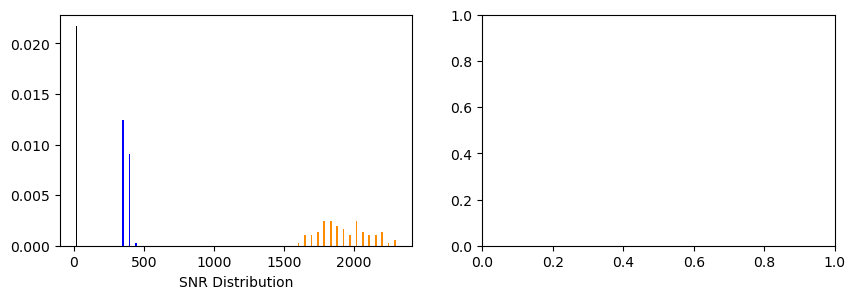

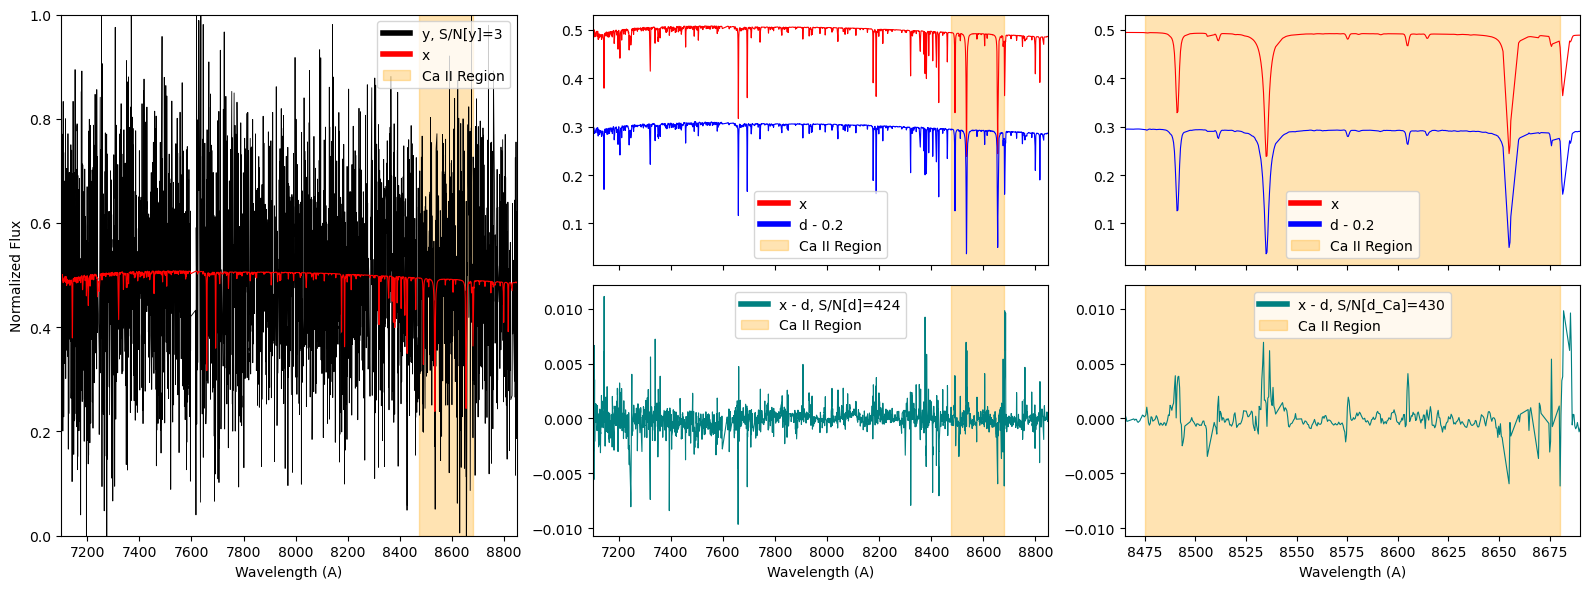

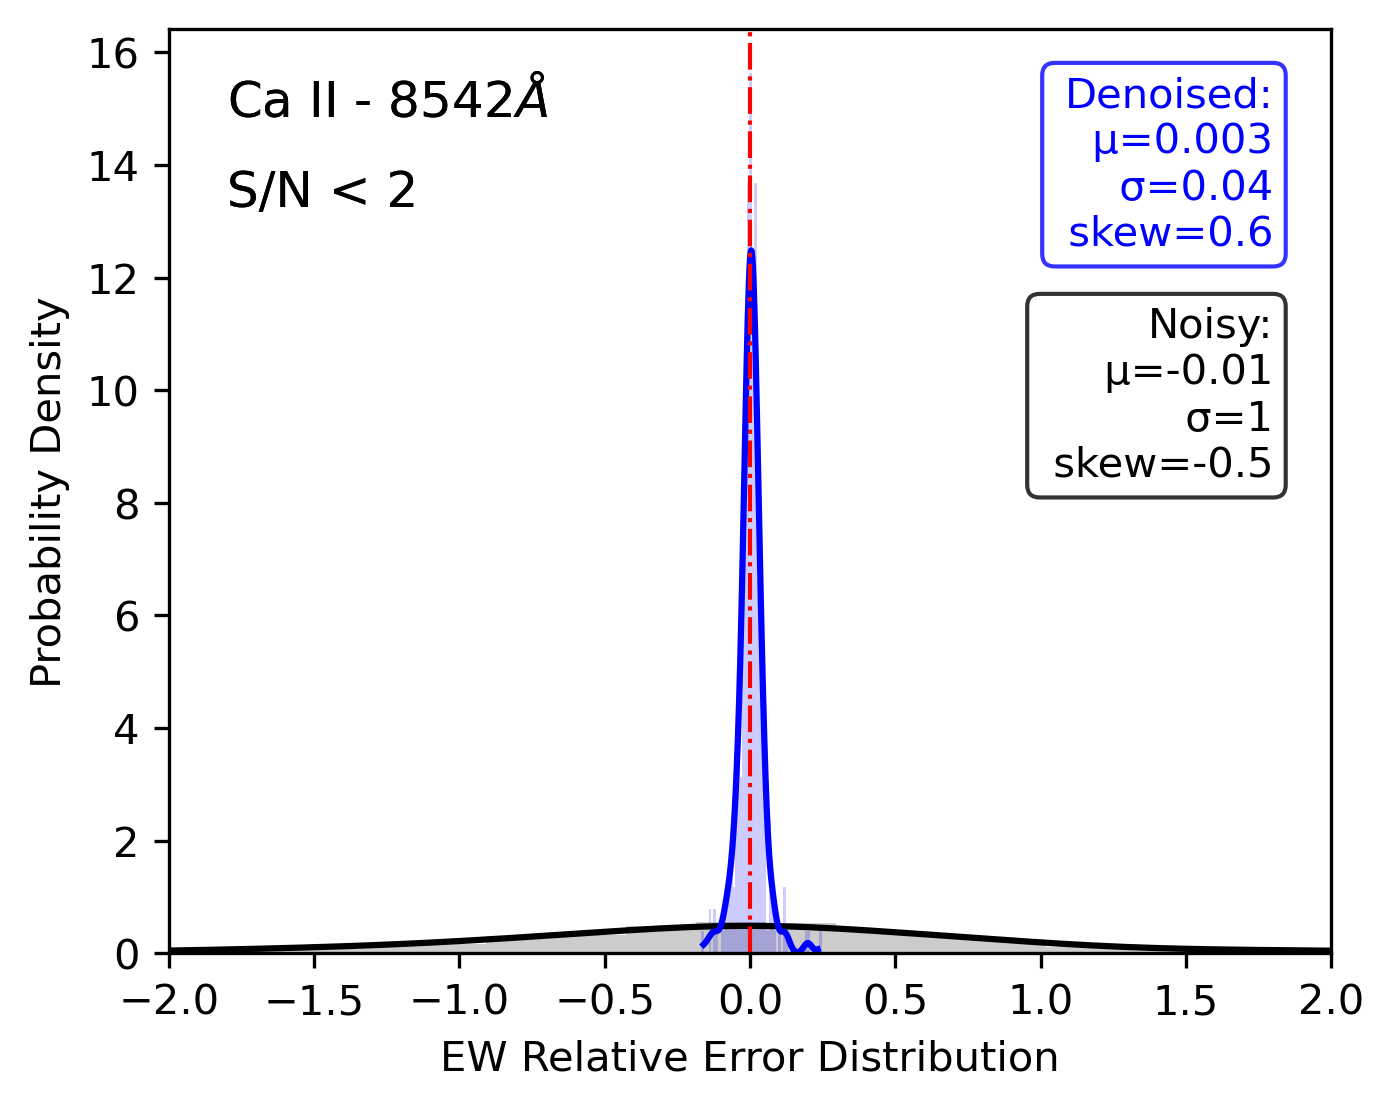

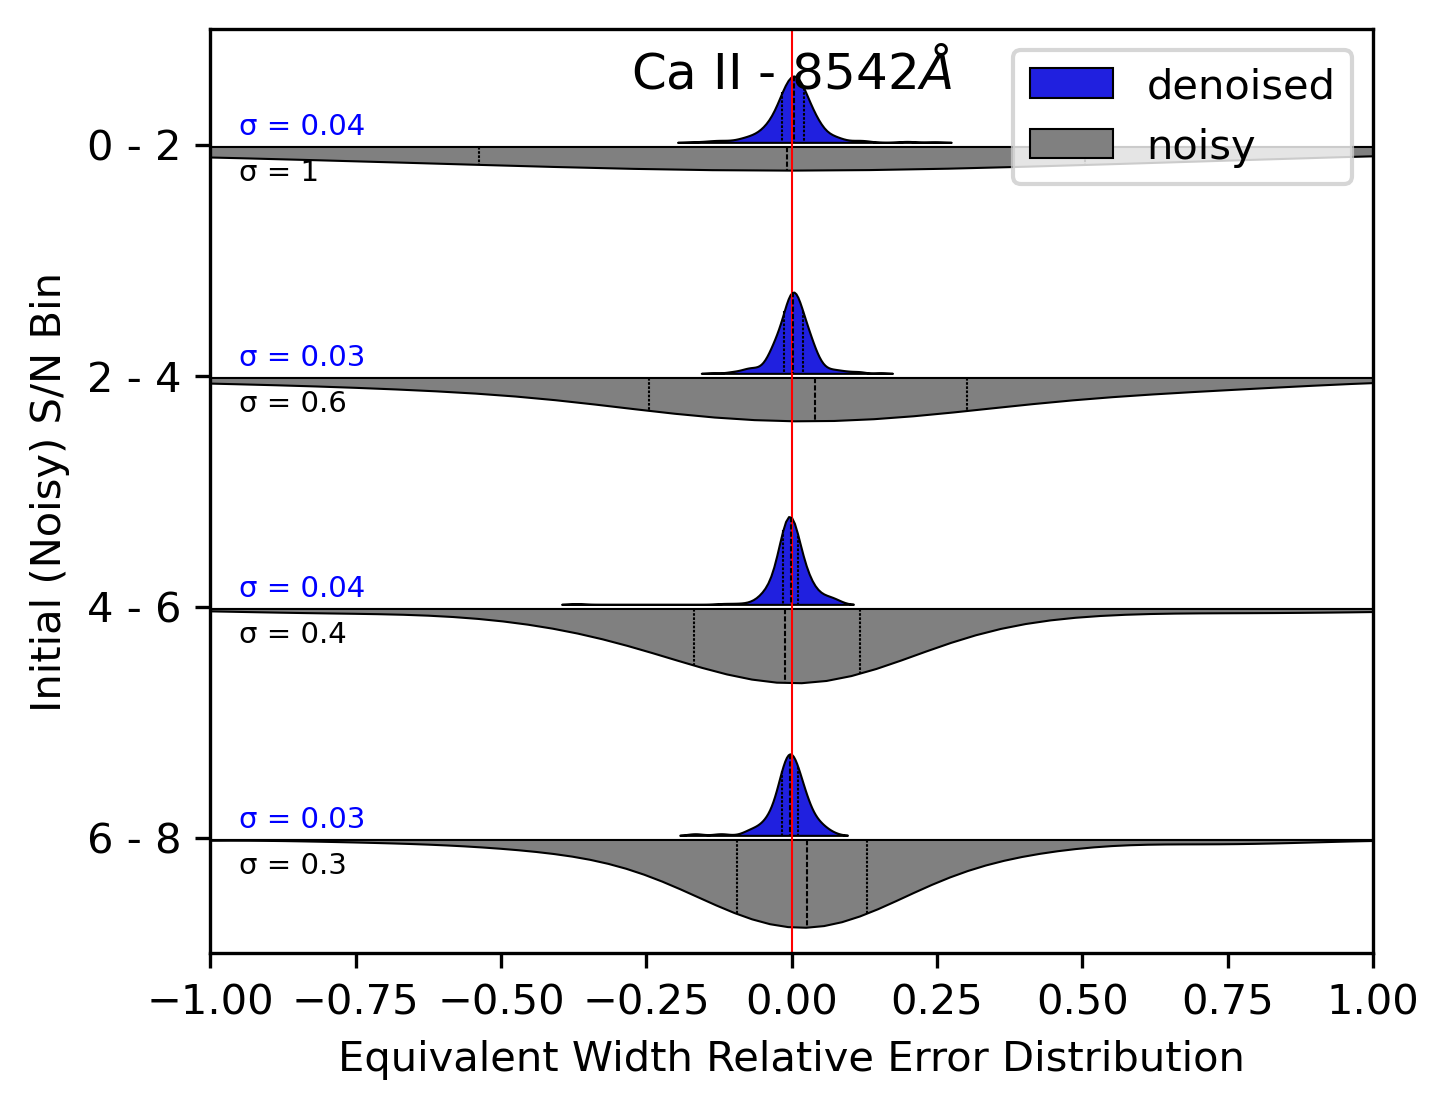

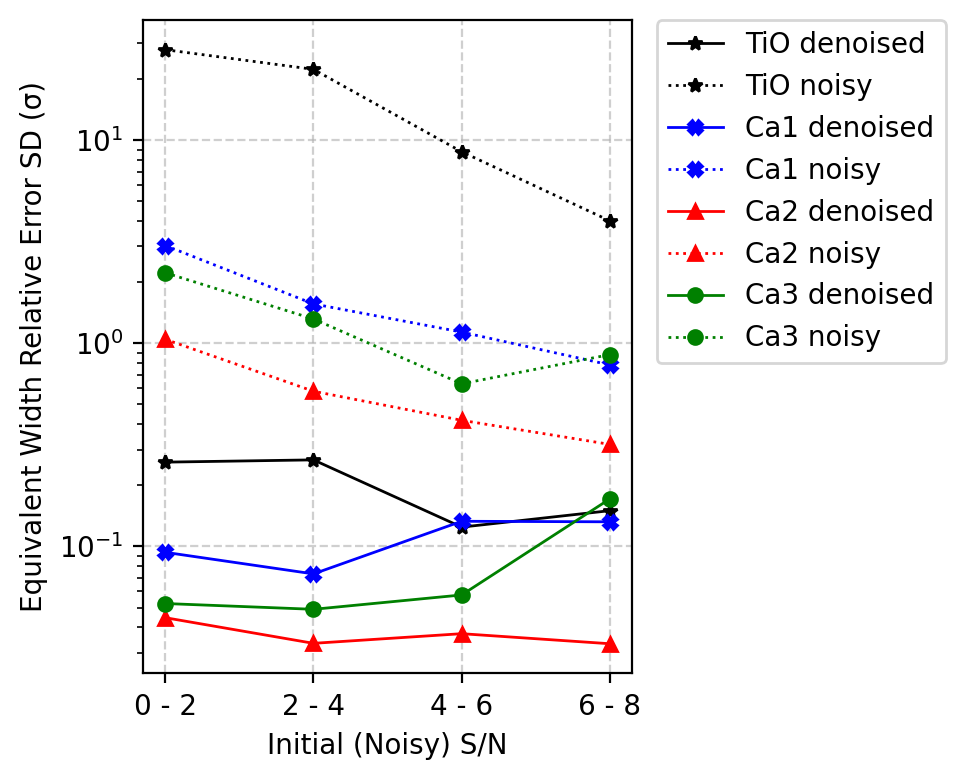

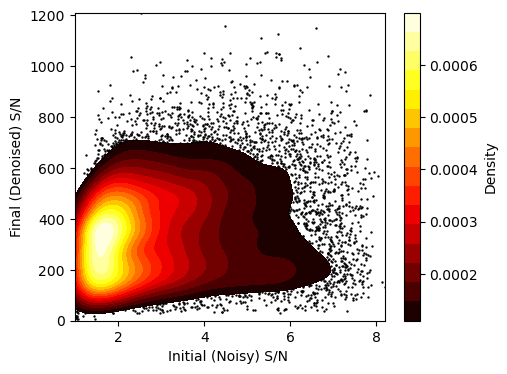

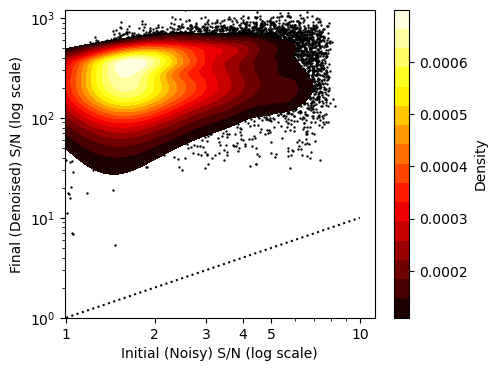

In [6]:
t = SpecTrainer(config=config, logger=False, num_gpus=1)
t.test_trainer.test(pl, datamodule=pl.data_module)

In [7]:
import torch
from torch.utils.data import DataLoader
idxs = [815]
results = {}
for idx in idxs:
    single_test_ds = pl.data_module.test.get_single_spectrum_noise_testset(sample_idx=idx, repeat=10000)
    single_test_dl = DataLoader(single_test_ds, batch_size=128)
    pl.cuda()
    pl.eval()    # 切换到eval模式
    pl.freeze()  # Lightning里可选，表示不更新梯度

    denoised_all = []
    with torch.no_grad():
        for batch in single_test_dl:
            noisy, flux, error = batch
            if torch.cuda.is_available():
                noisy = noisy.cuda()
                flux = flux.cuda()
                error = error.cuda()

            output_dict = pl(noisy, flux, error * pl.data_module.test.noise_level, loss_only=False)
            # print(output_dict['log_dict']['snr0'])
            denoised_all.append(output_dict['denoised'].detach().cpu())
    denoised_all = torch.cat(denoised_all, dim=0)  # [repeat, L]
    # mean_spectrum = denoised_all.mean(dim=0).values
    mean_spectrum = denoised_all.mean(dim=0)
    
    std_spectrum = denoised_all.std(dim=0)
    results[idx] = {
        "mean": mean_spectrum,
        "bias": mean_spectrum - single_test_ds.flux_0,
        "std": std_spectrum,
        'flux': single_test_ds.flux_0,
        'error': single_test_ds.error_0,
    }

torch.Size([10000, 3481]) torch.Size([3481]) torch.Size([3481])


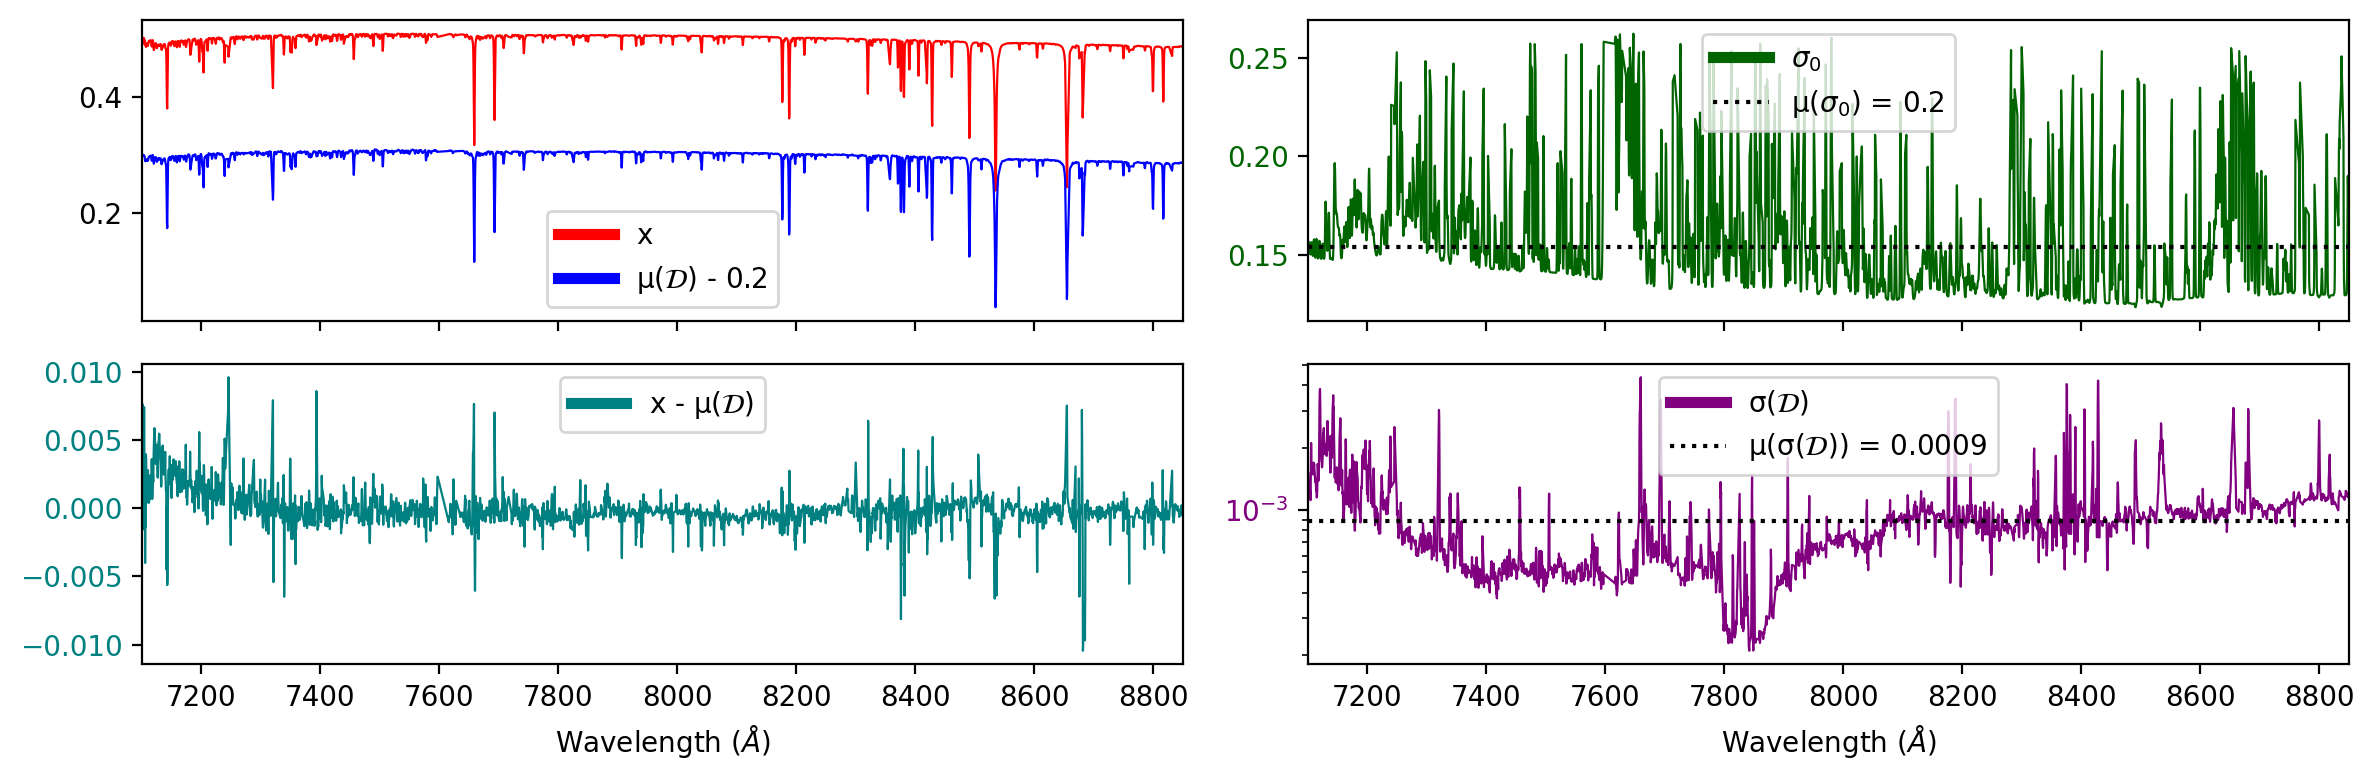

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2*len(idxs), ncols=2, figsize=(12, 4 * len(idxs)), dpi=200, sharex=True)

for row_i, idx in enumerate(idxs):
    flux = results[idx]['flux']
    error = results[idx]['error']
    bias_spectrum = results[idx]['bias']
    std_spectrum = results[idx]['std']
    mean_spectrum = results[idx]['mean']
    
    # Calculate row indices for this object (each object takes 2 rows)
    top_row = 2*row_i
    bottom_row = 2*row_i + 1
    
    # First column plots (original flux and flux - median)
    ax_flux = axes[top_row, 0] if len(idxs) > 1 else axes[0, 0]  # Top-left
    ax_flux_diff = axes[bottom_row, 0] if len(idxs) > 1 else axes[1, 0]  # Bottom-left
    
    # Plot flux in top-left
    ax_flux.plot(pl.wave, flux, c='r', lw=0.8, label=f'x')
    ax_flux.plot(pl.wave, mean_spectrum - 0.2, c='b', lw=0.8, label=r'μ($\mathcal{D}$) - 0.2')

    legend0 = ax_flux.legend(loc='lower center')
    for line in legend0.get_lines():
        line.set_linewidth(4)

    ax_flux.tick_params(axis='y', labelcolor='k')
    ax_flux.set(xlim=(pl.wave[0], pl.wave[-1]))
    if bottom_row == (2*len(idxs) - 1):  # Only label bottom plot
        ax_flux_diff.set(xlabel=rf'Wavelength ($\AA$)')
    
    # Plot flux - median in bottom-left
    c1 = 'teal'
    ax_flux_diff.plot(pl.wave, bias_spectrum, c=c1, lw=0.8, label=r'x - μ($\mathcal{D}$)', alpha=1)
    legend1 = ax_flux_diff.legend(loc='upper center')
    ax_flux_diff.tick_params(axis='y', labelcolor=c1)
    ax_flux_diff.set(xlim=(pl.wave[0], pl.wave[-1]))
    
    # Second column plots (std and error)
    ax_std = axes[bottom_row, 1] if len(idxs) > 1 else axes[1, 1]  # Bottom-right
    ax_error = axes[top_row, 1] if len(idxs) > 1 else axes[0, 1]  # top-right
    
    # Plot std in top-right
    mean0 = std_spectrum.mean()
    c2 = 'purple'
    ax_std.plot(pl.wave, std_spectrum, c=c2, lw=0.8, 
               label=r'σ($\mathcal{D}$)', alpha=1)
    ax_std.axhline(mean0, color='k', linestyle=':', 
                  label=r'μ(σ($\mathcal{D}$)) = ' + f'{mean0:.1g}')
    ax_std.set(xlim=(pl.wave[0], pl.wave[-1]), yscale='log')
    legend2 = ax_std.legend(loc='upper center')
    ax_std.tick_params(axis='y', labelcolor=c2)
    
    # Plot error in bottom-right
    mean1 = error.mean()
    c3 = 'darkgreen'
    ax_error.plot(pl.wave, error, c=c3, alpha=1, lw=0.8, label=fr'$\sigma_0$')
    ax_error.axhline(mean1, color='k', linestyle=':', label=fr'μ($\sigma_0$) = {(mean1):.1g}')
    legend3 = ax_error.legend(loc='upper center')
    ax_error.tick_params(axis='y', labelcolor=c3)
    ax_error.set(xlim=(pl.wave[0], pl.wave[-1]))
    if bottom_row == (2*len(idxs) - 1):  # Only label bottom plot
        ax_std.set(xlabel=rf'Wavelength ($\AA$)')

    # Adjust line widths in legends for this object's plots
    for legend in [legend1, legend2, legend3]:
        legend.get_lines()[0].set_linewidth(4)
        # for line in :/
            # line.set_linewidth(4)

plt.tight_layout()

# RV fitting

In [9]:
import os
import numpy as np
# _=pl.data_module.test.load_snr('test')
_=pl.data_module.test.load_params('test')
ep = 5000
res = 'bosz50000'
cutoff=500
mask = np.array([True if abs(rv) <= cutoff else False for rv in pl.data_module.test.rv])
save_name = f'{pl.model.name}_snr{pl.data_module.test.snr0.mean():.0f}_b50000_rv{cutoff}_ep{ep}_N{pl.data_module.test.snr[mask].shape[0]}.npz'
path = os.path.join('/datascope/subaru/user/swei20/blindspot_rv/inputs', res, save_name)
path

'/datascope/subaru/user/swei20/blindspot_rv/inputs/bosz50000/b1_l9_e48_k25_s1_bn1_d1_snr8_b50000_rv500_ep5000_N10000.npz'

In [ ]:
np.savez(path, 
         nl = pl.data_module.test.noise_level,
         denoised = pl.data_module.test.denoised[mask].numpy(),
         flux = pl.data_module.test.flux[mask].numpy(),
         noisy = pl.data_module.test.noisy[mask].numpy(),
         wave = pl.data_module.test.wave,
         flux_err = pl.data_module.test.error.numpy(),
         rv = np.array(pl.data_module.test.rv)[mask],
        teff = pl.data_module.test.teff[mask],
        logg = pl.data_module.test.logg[mask],
        mh= pl.data_module.test.mh[mask],
        snr0 = pl.data_module.test.snr0[mask],
        snr = pl.data_module.test.snr[mask]
    )

# Template fitting - Artificial Line Recovery

In [14]:
def plot_artificial_line1(ndx, snr_bins, noise_levels, loc_list, flux_list, denoised_list, noisy_list, hw=20, model_name=''):
    num_rows = len(flux_list)  # Number of different flux instances
    num_cols = 3
    npad = len(noise_levels)
    noise_level = noise_levels[ndx]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), sharey=True)

    
    for i, (flux1, loc, denoised, noisy, snr0) in enumerate(zip(flux_list, loc_list, denoised_list, noisy_list, snr_bins)):
        mask =(wave>loc-hw) & (wave < loc+hw)

        ax0 = axes[i][0]
        ax0.plot(wave, noisy[npad + ndx],  c='k', label=f'Noise S/N={snr0:.0f}', alpha=0.5, lw=0.4)
        ax0.plot(wave, flux1[ndx],  c='r', linestyle=':', label='Clean Flux')
        ax0.plot(wave, flux1[npad + ndx],  c='orange', label=f'Line@{loc:.0f}')
        axes[i][1].plot(wave[mask], noisy[npad + ndx][mask],  c='k', label=f'Noise S/N={snr0:.0f}', alpha=0.1)
        
        # ax0.plot(wave, denoised[npad + ndx], c='b', label=f'denoised @{loc:.0f}')
        for ax in axes[i][1:]:
            ax.plot(wave[mask], flux1[ndx][mask],  c='r', linestyle=':', label='Clean Flux')
            ax.plot(wave[mask], flux1[npad + ndx][mask],  c='orange', linestyle='--', label=f'Line@{loc:.0f}')
            ax.set_xlim(loc - hw, loc + hw)
            
        ax2 = axes[i][2]
        ax2.plot(wave[mask], denoised[ndx][mask], 'b-', lw=1, label='Denoised')
        ax2.plot(wave[mask], denoised[npad+ndx][mask], 'g-', lw=1, label='Denoised(Line)')
            # ax.set_title(f'Denoised NL={noise_level:.0f} S/N= {int(snr0/{noise_level})}')

        for ax in axes[i]: ax.legend(loc='lower left')
    axes[0][0].set(title=f'Noisy, Original Fluxs vs Artificial Line', ylim=(0,0.55))
    axes[0][1].set(title=f'Zoomed into Artificial Line')
    axes[0][2].set(title=f'{model_name} Denoised')
    plt.tight_layout()
    plt.show()

In [21]:
def get_indices(loc=8542, noise_levels = [0.1, 1, 2], snr_bins = [2.5, 5, 7.5, 10, 20, 40], cutoff=100,hw=20, sigma=1,gamma=2):
    tensor_values = pl.data_module.test.snr0[:cutoff]
    indices = torch.stack([torch.argmin(torch.abs(tensor_values - target)) for target in snr_bins])
    print(indices)
    noisy_list, flux_list, loc_list, denoised_list= [], [], [], []
    for i in indices:  # Each row corresponds to a different `flux1`
        noisys, flux1, denoised1, loc1 = pl.eval_artificial_line(loc=loc, idx=i, noise_levels=noise_levels, hw=hw, sigma=sigma, gamma=gamma)
        noisy_list.append(noisys)
        flux_list.append(flux1)
        loc_list.append(loc1)
        denoised_list.append(denoised1)
    plot_artificial_line1(0, snr_bins,noise_levels, loc_list, flux_list, denoised_list, noisy_list, model_name=pl.model.name)
    return flux_list, loc_list, denoised_list, noisy_list

In [22]:
# _=pl.data_module.test.load_snr('test', load_df=True)
# _=pl.data_module.test.load_params('test')
wave = pl.data_module.test.wave.numpy()

tensor([67, 82, 70])


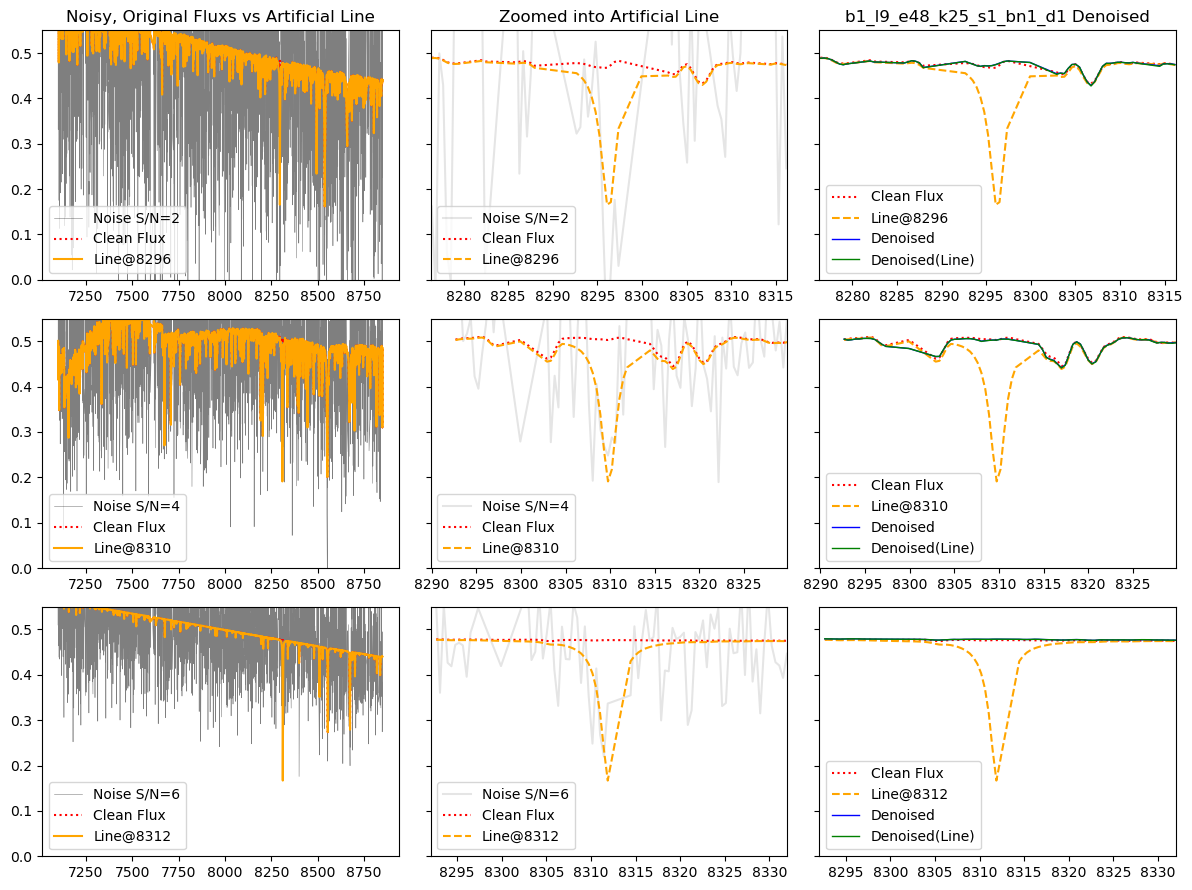

In [25]:
out = get_indices(loc=8300, noise_levels = [1], snr_bins = [2, 4, 6], cutoff=100,hw=20, sigma=0.1,gamma=1)

tensor([67, 82, 70])


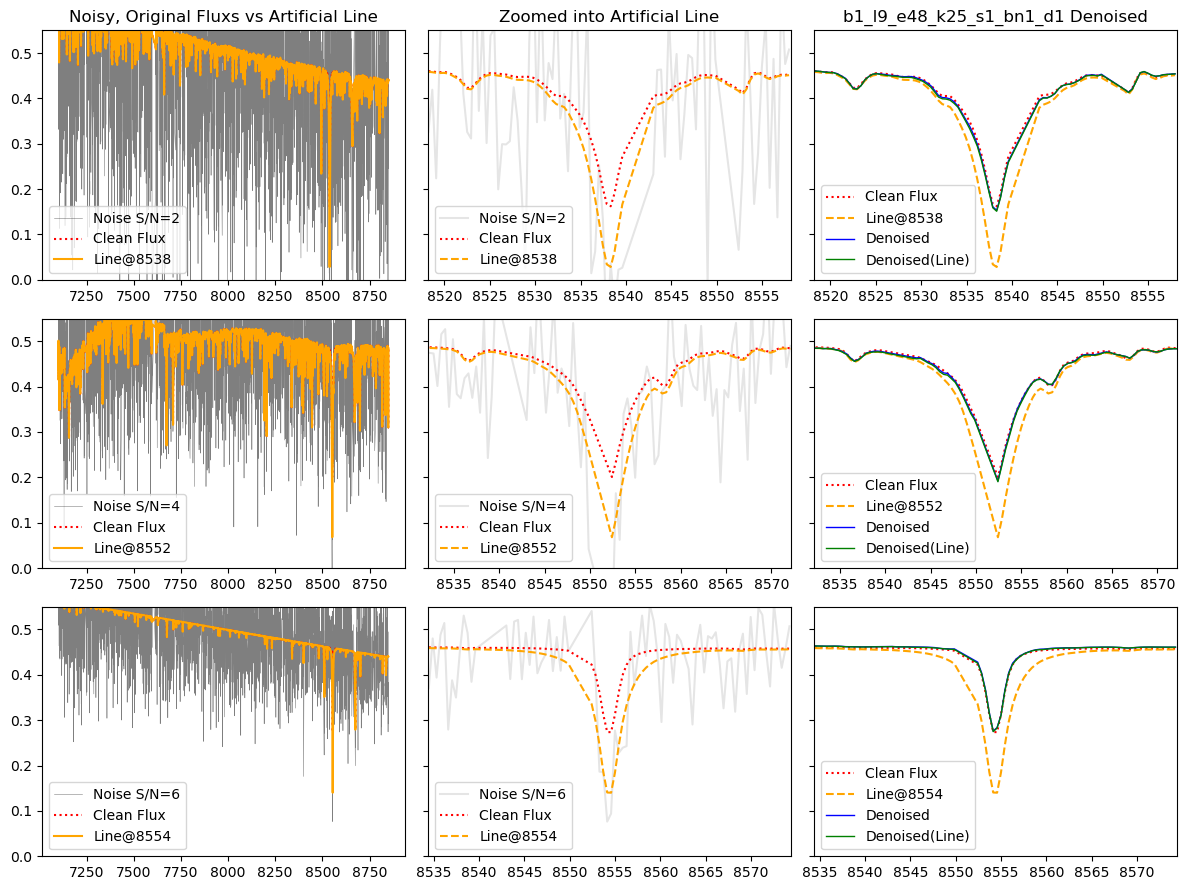

In [26]:
out1=get_indices(loc=8542, noise_levels = [1, 1], snr_bins = [2, 4, 6], cutoff=100,hw=20, sigma=1,gamma=2)

In [62]:
e[0].median()

tensor(0.1708)

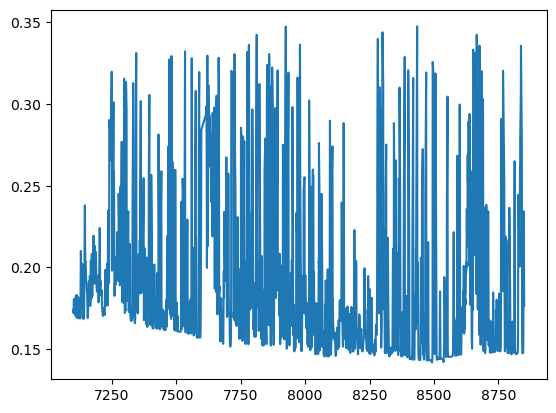

In [60]:
plt.plot(wave, e[0])

In [ ]:
torch.randn_like()

In [ ]:
idx = 4
n = pl.data_module.test.noise[idx:idx+1]
x = pl.data_module.test.flux[idx:idx+1]
x0 = torch.ones_like(x) * 0.5
e = pl.data_module.test.error[idx: idx+1]
e0 = torch.ones_like(x) * e.median()

denoised = pl.quick_test(n+x, x, e,).squeeze()
denoised0 = pl.quick_test(n+x0, x0, e,).squeeze()
denoised1 = pl.quick_test(x0+torch.torch.randn_like(x0), x0, e0,).squeeze()
denoised2 = pl.quick_test(n+x, x0, e0,).squeeze()



# outputs = pl.model(torch.cat([x, e], dim=0).unsqueeze(0))
# outputs0 = pl.model.compute_loss(torch.cat([x0, e], dim=0).unsqueeze(0))

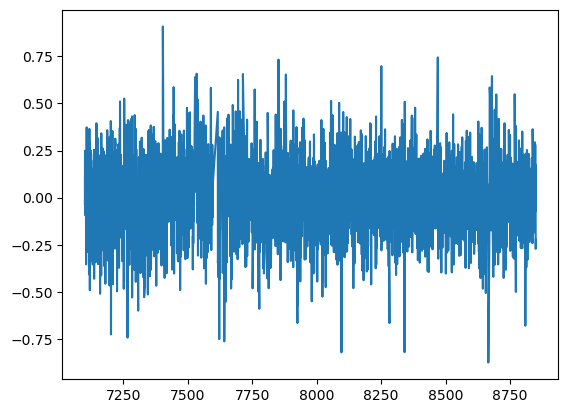

In [64]:
plt.plot(wave, n[0])

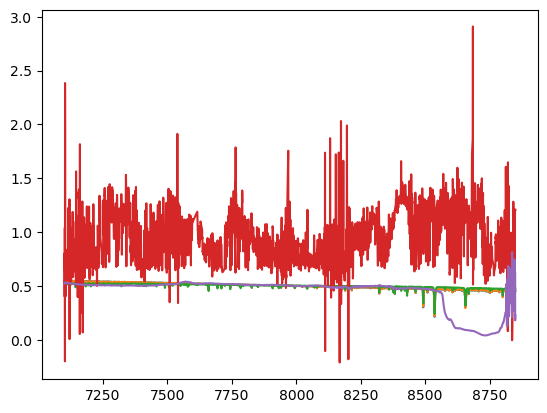

In [ ]:
plt.plot(wave, x[0])
plt.plot(wave, denoised)
plt.plot(wave, denoised0)




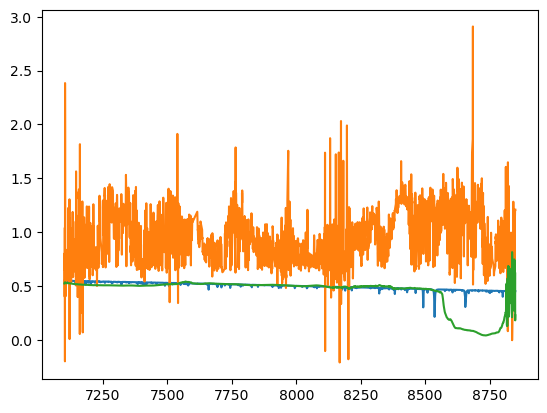

In [67]:
plt.plot(wave, x[0])
plt.plot(wave, denoised1)
plt.plot(wave, denoised2)